In [103]:
%load_ext autoreload

%matplotlib inline
%autoreload 2

# Supress nosiy deprecation warning from inside matplotlib
import warnings
warnings.filterwarnings('ignore')

import pandas
import matplotlib
import matplotlib.pyplot as plt
import folium
import math

import oslo

matplotlib.rcParams['figure.figsize'] = (20, 8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Download raw data
start = (2016, 6)
end = (2017, 8)
notexisting = [(2017, 1), (2017, 2), (2017, 3) ]
periods = sorted(set(oslo.months_between(start, end)).difference(notexisting))
for period in periods:
    try:
        filename = oslo.download_trip(*period)
    except Exception as e:
        raise RuntimeError("Could not download %d-%d: %s" % (*period, e.msg))
"done"

skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.6.1-2016.6.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.7.1-2016.7.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.8.1-2016.8.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.9.1-2016.9.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.10.1-2016.10.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.11.1-2016.11.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.12.1-2016.12.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2017.4.1-2017.4.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2017.5.1-2017.5.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2017.6.1-2017.6.30.csv.zip
skipping existing http:/

'done'

In [3]:
stations = oslo.read_stations()
print("%d stations" % len(stations.keys()))
stations[157]

153 stations


{'bounds': [{'latitude': 59.915418602160436, 'longitude': 10.762068629264832},
  {'latitude': 59.91565254992276, 'longitude': 10.762672126293182},
  {'latitude': 59.915807169665264, 'longitude': 10.762433409690855},
  {'latitude': 59.91557994562126, 'longitude': 10.761821866035461},
  {'latitude': 59.915418602160436, 'longitude': 10.762068629264832}],
 'center': {'latitude': 59.91562, 'longitude': 10.762248},
 'id': 157,
 'in_service': True,
 'number_of_locks': 30,
 'subtitle': 'mellom Norbygata og Urtegata',
 'title': 'Nylandsveien'}

In [146]:
map_center = [59.925, 10.75]
map_zoom = 12
station_map = folium.Map(location=map_center, zoom_start=map_zoom)

for _, station in stations.items():
    center = station['center']
    lon, lat = center['longitude'], center['latitude']
    folium.CircleMarker([lat, lon],
                radius=1, popup=station['title'],
                color='#dd0000', fill_color='#dd0000',
    ).add_to(station_map)
    
station_map

In [5]:
# Read in the files
# NOTE: Full set uses about 700MB of RAM, and 1 minutes to load
trips = pandas.DataFrame()
for period in periods[:1]:
    filename = "data/"+ oslo.trips_basename(*period)+'.csv'
    print('reading', filename)
    frame = pandas.read_csv(filename, index_col=None, header=0, parse_dates=[1, 3])
    trips = pandas.concat([trips, frame])
trips[:3]

reading data/trips-2016.6.1-2016.6.30.csv


,Start station,Start time,End station,End time
0,226,2016-06-01 03:59:59,243,2016-06-01 04:02:14
1,206,2016-06-01 04:00:02,212,2016-06-01 04:18:46
2,290,2016-06-01 04:00:06,261,2016-06-01 04:02:14


In [6]:
number_trips = trips.shape[0]
number_trips

292302

In [7]:
trips.set_index(['Start time'], drop=False, inplace=True)
first = trips['Start time'].min()
last = trips['Start time'].max()
first, last

(Timestamp('2016-06-01 03:59:59'), Timestamp('2016-06-30 21:59:53'))

In [8]:
len(trips['End station'].unique())

110

   ## Enriching the data

In [9]:
# Add trip durations intervals
trips['Duration'] = trips['End time'] - trips['Start time']
# Convert from nanoseconds, remove timedelta type
trips['Duration Seconds'] = pandas.Series(trips['Duration'], dtype='int64').abs() / (1000*1000*1000)

In [10]:
# Add distance of the trip
# Note: a bit slow, since doing geometric calculations in pure Python
subs = trips
subs['Distance'] = subs.apply(lambda r: oslo.calculate_distance(stations, r), 'columns')

In [11]:
# Add overall velocity (m/s)
trips['Velocity'] = trips['Distance'] / trips['Duration Seconds'] 
trips[:3]

,Start station,Start time,End station,End time,Duration,Duration Seconds,Distance,Velocity
Start time,,,,,,,,
2016-06-01 03:59:59,226,2016-06-01 03:59:59,243,2016-06-01 04:02:14,00:02:15,135.0,610.115142,4.519371
2016-06-01 04:00:02,206,2016-06-01 04:00:02,212,2016-06-01 04:18:46,00:18:44,1124.0,2917.746920,2.595860
2016-06-01 04:00:06,290,2016-06-01 04:00:06,261,2016-06-01 04:02:14,00:02:08,128.0,354.690116,2.771017


## Cleaning the data

In [12]:
### Do people return to same station often?
import numpy
self_ = trips[trips['Start station'].eq(trips['End station'])]
len(self_)/len(trips)*100
# About 5-10% of the trips go back to same stations

7.850784462644798

In [13]:
# 30% of return-to-same trips are below 1 minute.
# Where as < 3% of all trips are below. Probably errors!
minimum_duration = 1*60
own_trips = trips[trips['Start station'] == (trips['End station'])]
veryshort = trips[trips['Duration Seconds'] < minimum_duration]
invalid = own_trips[own_trips['Duration Seconds'] < minimum_duration] 

possibly_valid = (len(veryshort)-len(invalid))/len(trips)
print("""
Eliminating trips under %d sec.
%.3f%% of start!=end trips
%d start==trips""" % (minimum_duration, 100*possibly_valid, len(invalid)))


Eliminating trips under 60 sec.
0.021% of start!=end trips
7797 start==trips


In [14]:
# Eliminating
valid = trips['Duration Seconds'] > minimum_duration
trips = trips[valid]
len(trips)

284379

In [15]:
# Trips with missing start/end stations
missing_start = trips[pandas.isnull(trips['Start station'])]
missing_end = trips[pandas.isnull(trips['End station'])]
len(missing_start + missing_end)

0

In [16]:
# Find missing station info
def not_nan(n):
    return not math.isnan(n)
known_stations = set(stations.keys())
start_stations = set(filter(not_nan, trips['Start station'].unique()))
end_stations =  set(filter(not_nan, trips['End station'].unique()))
trip_stations = start_stations | end_stations
unknown_stations = trip_stations - known_stations
print(unknown_stations)

len(trips[trips['End station'].isin(unknown_stations)]), len(trips[trips['Start station'].isin(unknown_stations)])

{288, 172, 173, 271, 186}


(10500, 9403)

## Basic characteristics

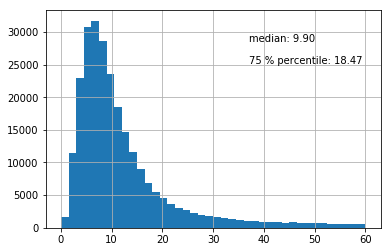

In [17]:
percentile_lim = 0.75
duration_mean = trips['Duration Seconds'].median() / 60
percentile = trips['Duration Seconds'].quantile(percentile_lim) / 60 
(trips['Duration Seconds'] / 60).hist(bins=40, range=(0, 60))
plt.text(.6, .8, 'median: %.2f' % (duration_mean), fontsize=10, transform=ax.transAxes)
plt.text(.6, .7, '%d %% percentile: %.2f' % (percentile_lim*100 ,percentile), fontsize=10, transform=ax.transAxes)

In [18]:
trips['Duration Seconds'].max()/(3600*24)

22.693287037037038

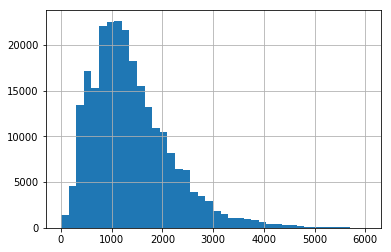

In [19]:
# 0 is a very common distance (travel back to self), ignore it
trips['Distance'].hist(bins=40, range=(1, 6000))

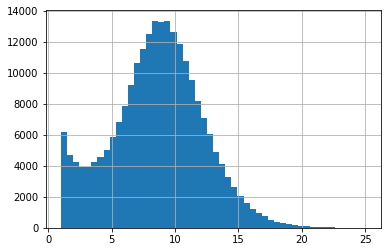

In [20]:
(trips['Velocity'] * 3.6).hist(bins=50, range=(1,25))

In [21]:
def span_show(ax, early, late):
    ax.axvspan(xmin=early[0], xmax=early[1], alpha=0.3, color='orange')
    ax.axvspan(xmin=late[0], xmax=late[1], alpha=0.3, color='red')

morning_span = (5*3600, 7*3600)
evening_span = (15*3600, 17*3600)
# TODO: Write time spans as time of day instead of seconds

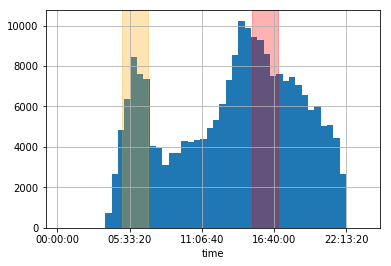

In [22]:
timeofday = trips.copy()
timeofday['timeofday'] = trips.index.time
series = timeofday['timeofday']
axs = series[trips.index.weekday < 5].hist(bins=48)
span_show(axs, morning_span, evening_span)

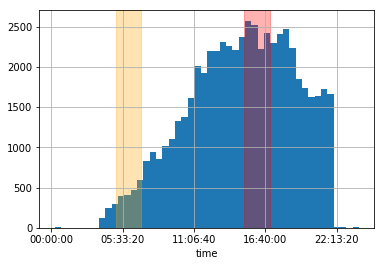

In [23]:
series = timeofday['timeofday']
axs = series[trips.index.weekday >= 5].hist(bins=48)
span_show(axs, morning_span, evening_span)

## Station connectivity

In [24]:
# How are stations connected to eachother?
period = trips['2016-06-03':'2016-07-13']
cross = pandas.crosstab(period['Start station'], period['End station'])
relative = cross.div(cross.sum(axis=1), axis=0)
relative[:3]

End station,157,159,160,161,162,163,164,167,170,172,...,287,288,290,291,292,293,294,298,301,302
Start station,,,,,,,,,,,,,,,,,,,,,
157,0.080529,0.000000,0.005609,0.000000,0.004808,0.031250,0.020433,0.003205,0.000000,0.002404,...,0.010817,0.015224,0.000401,0.000000,0.002003,0.001603,0.030048,0.000000,0.007612,0.013622
159,0.004021,0.074397,0.004021,0.004692,0.020107,0.016086,0.011394,0.002011,0.000000,0.006702,...,0.004021,0.005362,0.000670,0.003351,0.003351,0.004021,0.020777,0.002011,0.002681,0.009383
160,0.004338,0.002366,0.052445,0.003155,0.006309,0.011830,0.012224,0.008281,0.000789,0.001972,...,0.012618,0.006309,0.006309,0.000789,0.018533,0.008281,0.023659,0.003155,0.007492,0.020110


In [150]:
df = trips['2016-06-03':'2016-07-03']
df = df[df.index.weekday >= 5]
clustered = oslo.cluster_connected(df, n_clusters=6)
#print([len(c) for c in clustered])
oslo.plot_station_groups(stations, clustered)

In [151]:
df = trips[trips.index.weekday < 5 ]
#df = df.between_time('10:00', '12:00')
clustered = oslo.cluster_connected(df, n_clusters=6)
oslo.plot_station_groups(stations, clustered)

In [152]:
df = trips[trips.index.weekday < 5 ]
df = df.between_time('5:00', '8:00')
clustered = oslo.cluster_connected(df, n_clusters=6)
oslo.plot_station_groups(stations, clustered)

In [99]:
stats = oslo.cluster_stats(stations, trips, clustered)
# TODO: sanity check clustering
stats

,0,1,2,3,4,5
0,73409.0,20280.0,12595.0,5661.0,7555.0,1603.0
1,25928.0,29234.0,8170.0,8043.0,2905.0,719.0
2,16571.0,8807.0,8702.0,2017.0,3159.0,1454.0
3,6923.0,6610.0,1677.0,5551.0,507.0,140.0
4,9741.0,3499.0,3165.0,666.0,3612.0,460.0
5,1860.0,864.0,1582.0,170.0,421.0,119.0


In [153]:
# Visualize clustered connectivity
dot = oslo.cluster_digraph(clustered, stats)

#dot    

In [174]:
df = (trips[trips.index.weekday < 5 ]).between_time('5:00', '8:00')
clustered, centers, st = oslo.cluster_connected(df, n_clusters=6, method='affinitypropagation')
center_stations = list(map(lambda idx: st.values[idx], centers))
m = oslo.plot_station_groups(stations, clustered, center_stations)
m.save('affinity-cluster-workday-commute.html')
m

In [175]:
df = (trips[trips.index.weekday >= 5 ])
clustered, centers, st = oslo.cluster_connected(df, n_clusters=6, method='affinitypropagation')
center_stations = list(map(lambda idx: st.values[idx], centers))
m = oslo.plot_station_groups(stations, clustered, center_stations)
m.save('affinity-cluster-weekend.html')
m

TypeError: 'int' object is not iterable